This first cel is the Hourly charging forecast using Lgbm.

C:\Users\user\AppData\Local\Temp\ipykernel_24676\2853287432.py:20: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 6960, number of used features: 7
[LightGBM] [Info] Start training from score 11.209267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 437
[LightGBM] [Info] Number of data points in the train set: 6984, number of used features: 7
[LightGBM] [Info] Start training from score 11.171286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

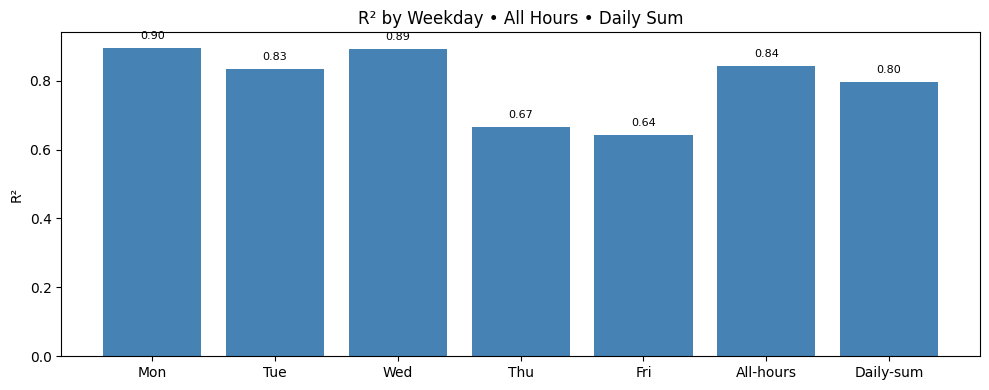

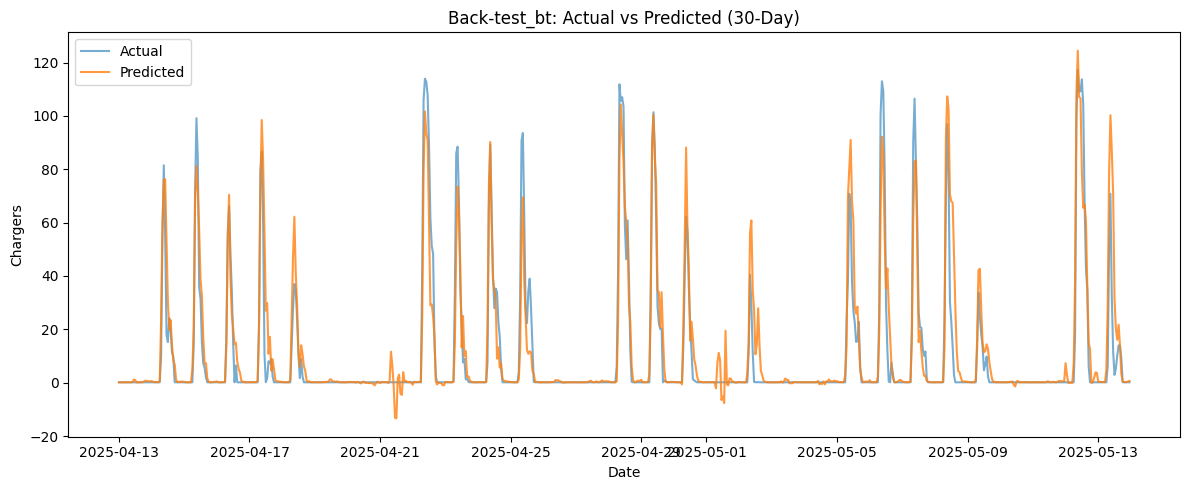

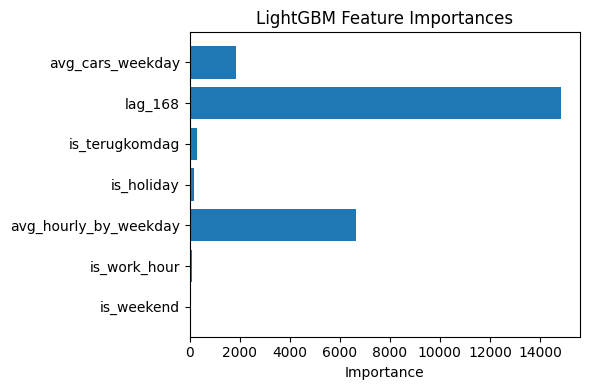

In [3]:
import pandas as pd, numpy as np, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────── 1  LOAD DATA ───────────────────────
df = pd.read_csv("./charging_forecasts/Charging_data_hourly.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Chargers': 'y'})    # hourly kWh

# ─────────────────────── 2  STATIC FLAGS ─────────────────────
tkd = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# core time flags
df['weekday']      = df['ds'].dt.weekday
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

SESSION_KWH = 9.5                         # average energy per vehicle-session

# 30-day evaluation window
start_eval = df['ds'].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df['ds'].max().normalize(),
                           freq='D')

all_preds = []                            # collect daily predictions

for day in days_iter:
    day_start = pd.Timestamp(day)         # 00:00 of target day
    day_end   = day_start + pd.Timedelta(days=1)

    # ──  TRAIN slice: everything before 00:00 of this day  ──
    train = df[df['ds'] < day_start].copy()
    # derive weekday/hour mean & weekday car average on **train only**
    avg_map = (train.groupby(['weekday','hour'])['y']
                     .mean().rename('avg_hourly_by_weekday')
                     .reset_index())
    train['lag_168'] = train['y'].shift(168).fillna(train['y'].mean())                      # fallback mean
    
    train = train.merge(avg_map, on=['weekday','hour'], how='left')
    train['avg_cars_weekday'] = (
        train.groupby('weekday')['y'].transform('mean') / SESSION_KWH
    )

    FEATURES = [
        'is_weekend','is_work_hour','avg_hourly_by_weekday',
        'is_holiday','is_terugkomdag',
        'lag_168','avg_cars_weekday'
    ]

    model = lgb.LGBMRegressor(
        objective='regression', alpha=0.55,
        n_estimators=800, learning_rate=0.05,
        random_state=42
    ).fit(train[FEATURES], train['y'])

    # ──  BUILD feature frame for the 24 h of this day  ──
    day_df = df[(df['ds'] >= day_start) & (df['ds'] < day_end)].copy()
    day_df = day_df.merge(avg_map, on=['weekday','hour'], how='left')

    lag_df = train[['ds','y']].copy()
    lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)
    lag_df.rename(columns={'y':'lag_168'}, inplace=True)
    day_df = day_df.merge(lag_df, on='ds', how='left')
    day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])

    

    cars_map = (train.groupby('weekday')['y'].mean() / SESSION_KWH
                ).rename('avg_cars_weekday').reset_index()
    day_df = day_df.merge(cars_map, on='weekday', how='left')

    # predict all 24 rows
    day_df['yhat'] = model.predict(day_df[FEATURES])
    all_preds.append(day_df[['ds','y','yhat','weekday']])

# ────────── CONCAT results & evaluate ──────────
test_bt = pd.concat(all_preds).sort_values('ds').reset_index(drop=True)

# ═════════════════ 7. METRICS ════════════════════════════════════════════════
mae  = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2   = r2_score(test_bt['y'], test_bt['yhat'])

print("\n--- Back-test_bt Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
r2_by_wd = {
    weekday_map[d]:
    r2_score(
        test_bt.loc[test_bt['weekday']==d,'y'],
        test_bt.loc[test_bt['weekday']==d,'yhat']
    )
    for d in range(5)
}

# R² on daily sums
daily = test_bt.groupby(test_bt['ds'].dt.date).agg(
    y_sum=('y','sum'),
    yhat_sum=('yhat','sum')
)
r2_daily = r2_score(daily['y_sum'], daily['yhat_sum'])

# ═════════════════ 8. PLOTS ════════════════════════════════════════════════
# R² bar plot
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily]
plt.figure(figsize=(10,4))
bars = plt.bar(labels, values, color='steelblue')
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar, v in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, v + 0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# Time-series plot & feature importances
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test_bt: Actual vs Predicted (30-Day)")
plt.xlabel("Date")
plt.ylabel("Chargers")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


This second cel contains a hourly building forecast using lgbm model.

C:\Users\user\AppData\Local\Temp\ipykernel_24676\1111648649.py:20: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 4440, number of used features: 6
[LightGBM] [Info] Start training from score 17.825595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 4464, number of used features: 6
[LightGBM] [Info] Start training from score 17.812425
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, y

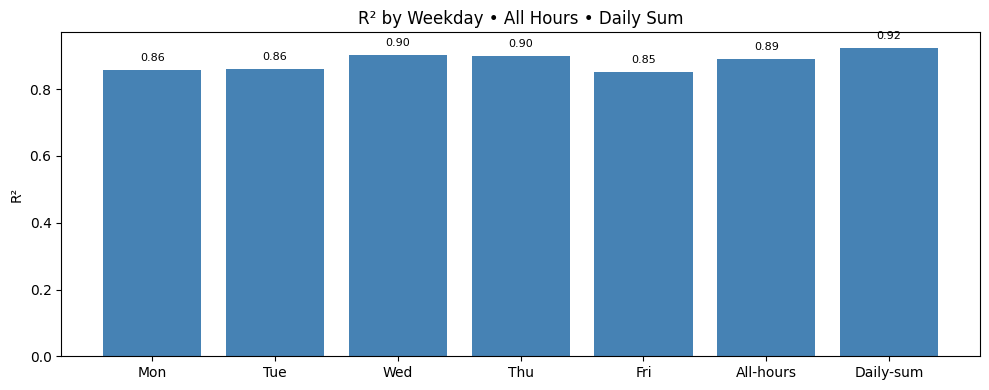

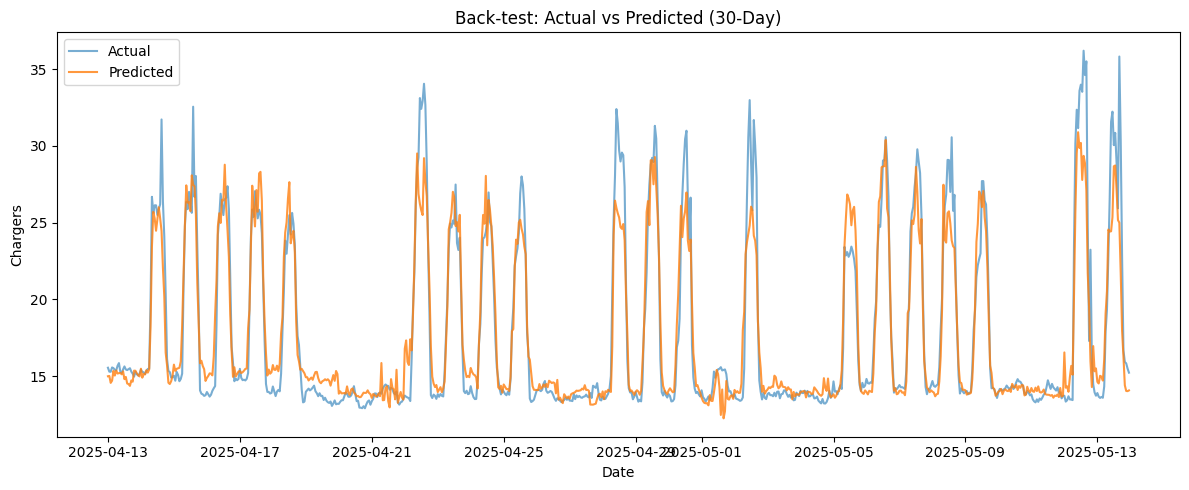

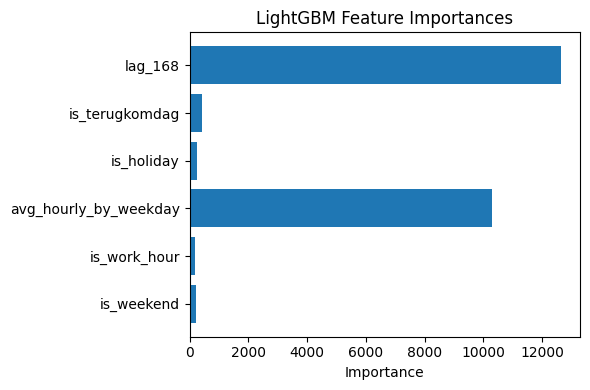

In [4]:
import pandas as pd, numpy as np, holidays, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ─────────────────────── 1  LOAD DATA ───────────────────────
df = pd.read_csv("./building_forecasts/building_data.csv")
df['ds'] = pd.to_datetime(df['Date'])
df = df.sort_values('ds').rename(columns={'Consumption': 'y'})    # hourly kWh

# ─────────────────────── 2  STATIC FLAGS ─────────────────────
tkd = pd.to_datetime([
    "2023-09-13","2023-10-26","2023-11-14","2023-12-20",
    "2024-01-12","2024-02-07","2024-03-14","2024-04-16",
    "2024-05-13","2024-06-07","2024-10-22","2024-11-28",
    "2024-12-18","2025-01-10","2025-02-13","2025-03-18",
    "2025-04-22","2025-05-12","2025-06-06",
]).normalize()
be_holidays = holidays.Belgium(years=df['ds'].dt.year.unique())

df['is_terugkomdag'] = df['ds'].dt.normalize().isin(tkd).astype(int)
df['is_holiday']     = df['ds'].dt.normalize().isin(be_holidays).astype(int)

# core time flags
df['weekday']      = df['ds'].dt.weekday
df['hour']         = df['ds'].dt.hour
df['is_weekend']   = (df['weekday'] >= 5).astype(int)
df['is_work_hour'] = ((df['hour'] >= 8) & (df['hour'] <= 18)).astype(int)

                        # average energy per vehicle-session

# 30-day evaluation window
start_eval = df['ds'].max() - pd.Timedelta(days=30)
days_iter  = pd.date_range(start_eval.normalize(),
                           df['ds'].max().normalize(),
                           freq='D')

all_preds = []                            # collect daily predictions

for day in days_iter:
    day_start = pd.Timestamp(day)         # 00:00 of target day
    day_end   = day_start + pd.Timedelta(days=1)

    # ──  TRAIN slice: everything before 00:00 of this day  ──
    train = df[df['ds'] < day_start].copy()
    # derive weekday/hour mean & weekday car average on **train only**
    avg_map = (train.groupby(['weekday','hour'])['y']
                     .mean().rename('avg_hourly_by_weekday')
                     .reset_index())
    train['lag_168'] = train['y'].shift(168).fillna(train['y'].mean())                      # fallback mean
    
    train = train.merge(avg_map, on=['weekday','hour'], how='left')
    

    FEATURES = [
        'is_weekend','is_work_hour','avg_hourly_by_weekday',
        'is_holiday','is_terugkomdag',
        'lag_168'
    ]

    model = lgb.LGBMRegressor(
        objective='regression', alpha=0.55,
        n_estimators=800, learning_rate=0.05,
        random_state=42
    ).fit(train[FEATURES], train['y'])

    # ──  BUILD feature frame for the 24 h of this day  ──
    day_df = df[(df['ds'] >= day_start) & (df['ds'] < day_end)].copy()
    day_df = day_df.merge(avg_map, on=['weekday','hour'], how='left')

    lag_df = train[['ds','y']].copy()
    lag_df['ds'] = lag_df['ds'] + pd.Timedelta(days=7)
    lag_df.rename(columns={'y':'lag_168'}, inplace=True)
    day_df = day_df.merge(lag_df, on='ds', how='left')
    day_df['lag_168'] = day_df['lag_168'].fillna(day_df['avg_hourly_by_weekday'])
    
    # predict all 24 rows
    day_df['yhat'] = model.predict(day_df[FEATURES])
    all_preds.append(day_df[['ds','y','yhat','weekday']])

# ────────── CONCAT results & evaluate ──────────
test_bt = pd.concat(all_preds).sort_values('ds').reset_index(drop=True)

# ═════════════════ 9. METRICS ═══════════════════════════════════════════════
mae  = mean_absolute_error(test_bt['y'], test_bt['yhat'])
rmse = np.sqrt(mean_squared_error(test_bt['y'], test_bt['yhat']))
r2   = r2_score(test_bt['y'], test_bt['yhat'])

print("\n--- Back-test Metrics (Last 30 Days) ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.2f}")

# R² by weekday
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri'}
r2_by_wd = {weekday_map[d]:
            r2_score(test_bt.loc[test_bt['weekday']==d,'y'],
                     test_bt.loc[test_bt['weekday']==d,'yhat'])
            for d in range(5)}

# R² on daily sums
daily = test_bt.groupby(test_bt['ds'].dt.date).agg(
        y_sum=('y','sum'), yhat_sum=('yhat','sum'))
r2_daily_sum = r2_score(daily['y_sum'], daily['yhat_sum'])

# ═════════════════ 10. R² BAR PLOT ══════════════════════════════════════════
labels = list(r2_by_wd.keys()) + ['All-hours','Daily-sum']
values = list(r2_by_wd.values()) + [r2, r2_daily_sum]

plt.figure(figsize=(10,4))
bars = plt.bar(labels, values, color='steelblue')
plt.axhline(0, color='k', linewidth=0.7)
plt.ylabel("R²")
plt.title("R² by Weekday • All Hours • Daily Sum")
for bar,v in zip(bars,values):
    plt.text(bar.get_x()+bar.get_width()/2, v+0.02, f"{v:.2f}",
             ha='center', va='bottom', fontsize=8)
plt.tight_layout(); plt.show()

# ═════════════════ 11. TIME-SERIES PLOT & FEATURE IMPORTANCE ════════════════
plt.figure(figsize=(12,5))
plt.plot(test_bt['ds'], test_bt['y'],    label='Actual',    alpha=0.6)
plt.plot(test_bt['ds'], test_bt['yhat'], label='Predicted', alpha=0.8)
plt.title("Back-test: Actual vs Predicted (30-Day)")
plt.xlabel("Date"); plt.ylabel("Chargers")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.barh(FEATURES, model.feature_importances_)
plt.title("LightGBM Feature Importances")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()
